<a href="https://colab.research.google.com/github/justintracyy/OmdenaSchool_MasteringComputerVision/blob/main/mastering_CV_session_two.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/AlexeyAB/darknet


Cloning into 'darknet'...
remote: Enumerating objects: 15395, done.
remote: Total 15395 (delta 0), reused 0 (delta 0), pack-reused 15395
Receiving objects: 100% (15395/15395), 14.02 MiB | 25.05 MiB/s, done.
Resolving deltas: 100% (10353/10353), done.


In [ ]:
%cd darknet

/content/darknet


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!sed -i 's/OPENCV=0/OPENCV=1/' Makefile
# !!! In case you dont have a GPU, make sure to comment out the below 3 lines !!! #
!sed -i 's/GPU=0/GPU=1/' Makefile
!sed -i 's/CUDNN=0/CUDNN=1/' Makefile
!sed -i 's/CUDNN_HALF=0/CUDNN_HALF=1/' Makefile
!make

mkdir -p ./obj/
mkdir -p backup
chmod +x *.sh
g++ -std=c++11 -std=c++11 -Iinclude/ -I3rdparty/stb/include -DOPENCV `pkg-config --cflags opencv4 2> /dev/null || pkg-config --cflags opencv` -DGPU -I/usr/local/cuda/include/ -DCUDNN -DCUDNN_HALF -Wall -Wfatal-errors -Wno-unused-result -Wno-unknown-pragmas -fPIC -Ofast -DOPENCV -DGPU -DCUDNN -I/usr/local/cudnn/include -DCUDNN_HALF -c ./src/image_opencv.cpp -o obj/image_opencv.o
./src/image_opencv.cpp: In function ‘void draw_detections_cv_v3(void**, detection*, int, float, char**, image**, int, int)’:
./src/image_opencv.cpp:946:23: warning: variable ‘rgb’ set but not used [-Wunused-but-set-variable]
                 float rgb[3];
                       ^~~
./src/image_opencv.cpp: In function ‘void draw_train_loss(char*, void**, int, float, float, int, int, float, int, char*, float, int, int, double)’:
./src/image_opencv.cpp:1147:13: warning: this ‘if’ clause does not guard... [-Wmisleading-indentation]
             if (iteration_old == 0)
  

In [ ]:
# !pip install -q torch_snippets
!tar -xf /content/drive/MyDrive/Omdena_Resources_for_Me/object-detection-bus-trucks.tar.xz
!rm object-detection-bus-trucks.tar.xz

rm: cannot remove 'object-detection-bus-trucks.tar.xz': No such file or directory


In [ ]:
!wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v3_optimal/yolov4.weights

A test on a single image

In [ ]:
!./darknet detector test cfg/coco.data cfg/yolov4.cfg yolov4.weights data/person.jpg

 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 8, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 1    608 x 608 x   3 ->  608 x 608 x  32 0.639 BF
   1 conv     64       3 x 3/ 2    608 x 608 x  32 ->  304 x 304 x  64 3.407 BF
   2 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   3 route  1 		                           ->  304 x 304 x  64 
   4 conv     64       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  64 0.757 BF
   5 conv     32       1 x 1/ 1    304 x 304 x  64 ->  304 x 304 x  32 0.379 BF
   6 conv     64       3 x 3/ 1    304 x 304 x  32 ->  304 x 304 x  64 3.407 BF
   7 Shortcut Layer: 4,  wt = 0, wn = 0, outputs: 304 x 304 x  64 0.006 BF
   8 conv  

In [ ]:
%%writefile data/obj.names
bus
truck

Writing data/obj.names


In [ ]:
%%writefile data/obj.data
classes = 2
train = data/train.txt
valid = data/val.txt
names = data/obj.names
backup = backup/

Writing data/obj.data


In [ ]:
!mkdir -p data/obj
!cp -r object-detection-bus-trucks/images/* data/obj/
!cp -r object-detection-bus-trucks/yolo_labels/all/{train,val}.txt data/
!cp -r object-detection-bus-trucks/yolo_labels/all/labels/*.txt data/obj/


1. Equation to set max batches `(classes*2000)`
2. Filters: `(classes + 5)x3` in the 3 convolutional layer.
3.   



In [ ]:
# create a copy of existing configuration and modify it in place
!cp cfg/yolov4-tiny-custom.cfg cfg/yolov4-tiny-bus-trucks.cfg

# max_batches to 4000 (since the dataset is small enough)
!sed -i 's/max_batches = 500200/max_batches=4000/' cfg/yolov4-tiny-bus-trucks.cfg

# number of sub-batches per batch
!sed -i 's/subdivisions=1/subdivisions=16/' cfg/yolov4-tiny-bus-trucks.cfg

# number of batches after which learning rate is decayed
!sed -i 's/steps=400000,450000/steps=3200,3600/' cfg/yolov4-tiny-bus-trucks.cfg

# number of classes is 2 as opposed to 80 (which is the number of COCO classes)
!sed -i 's/classes=80/classes=2/g' cfg/yolov4-tiny-bus-trucks.cfg

# in the classification and regression heads, change number of output convolution filters
# from 255 -> 21 and 57 -> 33, since we have fewer classes we don't need as many filters
!sed -i 's/filters=255/filters=21/g' cfg/yolov4-tiny-bus-trucks.cfg
!sed -i 's/filters=57/filters=33/g' cfg/yolov4-tiny-bus-trucks.cfg

In [ ]:
!wget --quiet https://github.com/AlexeyAB/darknet/releases/download/darknet_yolo_v4_pre/yolov4-tiny.conv.29
!cp yolov4-tiny.conv.29 build/darknet/x64/

In [ ]:
!./darknet detector train data/obj.data cfg/yolov4-tiny-bus-trucks.cfg yolov4-tiny.conv.29 -dont_show -mapLastAt

Streaming output truncated to the last 5000 lines.
 total_bbox = 81499, rewritten_bbox = 0.231905 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.818307), count: 4, class_loss = 0.720879, iou_loss = 0.288516, total_loss = 1.009395 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.001351, iou_loss = 0.000000, total_loss = 0.001351 
 total_bbox = 81503, rewritten_bbox = 0.231893 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.703170), count: 6, class_loss = 1.443606, iou_loss = 0.346756, total_loss = 1.790362 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 37 Avg (IOU: 0.000000), count: 1, class_loss = 0.013368, iou_loss = 0.000000, total_loss = 0.013368 
 total_bbox = 81509, rewritten_bbox = 0.231876 % 
v3 (iou loss, Normalizer: (iou: 0.07, obj: 1.00, cls: 1.00) Region 30 Avg (IOU: 0.700247), count: 3, class_loss = 0.766502, iou

[Guides_convert_to_tflite](https://github.com/Tianxiaomo/pytorch-YOLOv4)

Real time on video file.

In [ ]:
!./darknet detector demo data/obj.data cfg/yolov4-tiny-bus-trucks.cfg backup/yolov4-tiny-bus-trucks_final.weights -dont_show /content/buses_on_road.mp4 -i 0 -out_filename /content/output.mp4

In [ ]:
!pip install -q torch_snippets

     |████████████████████████████████| 42 kB 778 kB/s 
     |████████████████████████████████| 56 kB 4.0 MB/s 
     |████████████████████████████████| 214 kB 30.5 MB/s 
     |████████████████████████████████| 10.9 MB 48.8 MB/s 
     |████████████████████████████████| 57 kB 3.9 MB/s 
     |████████████████████████████████| 51 kB 6.5 MB/s 


 CUDA-version: 11010 (11020), cuDNN: 7.6.5, CUDNN_HALF=1, GPU count: 1  
 CUDNN_HALF=1 
 OpenCV version: 3.2.0
 0 : compute_capability = 370, cudnn_half = 0, GPU: Tesla K80 
net.optimized_memory = 0 
mini_batch = 1, batch = 16, time_steps = 1, train = 0 
   layer   filters  size/strd(dil)      input                output
   0 Create CUDA-stream - 0 
 Create cudnn-handle 0 
conv     32       3 x 3/ 2    416 x 416 x   3 ->  208 x 208 x  32 0.075 BF
   1 conv     64       3 x 3/ 2    208 x 208 x  32 ->  104 x 104 x  64 0.399 BF
   2 conv     64       3 x 3/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.797 BF
   3 route  2 		                       1/2 ->  104 x 104 x  32 
   4 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   5 conv     32       3 x 3/ 1    104 x 104 x  32 ->  104 x 104 x  32 0.199 BF
   6 route  5 4 	                           ->  104 x 104 x  64 
   7 conv     64       1 x 1/ 1    104 x 104 x  64 ->  104 x 104 x  64 0.089 BF
   8 route  2 7 	   

2022-01-08 11:47:57.804 | INFO     | torch_snippets.paths:inner:27 - 15 files found at *_pred.jpg


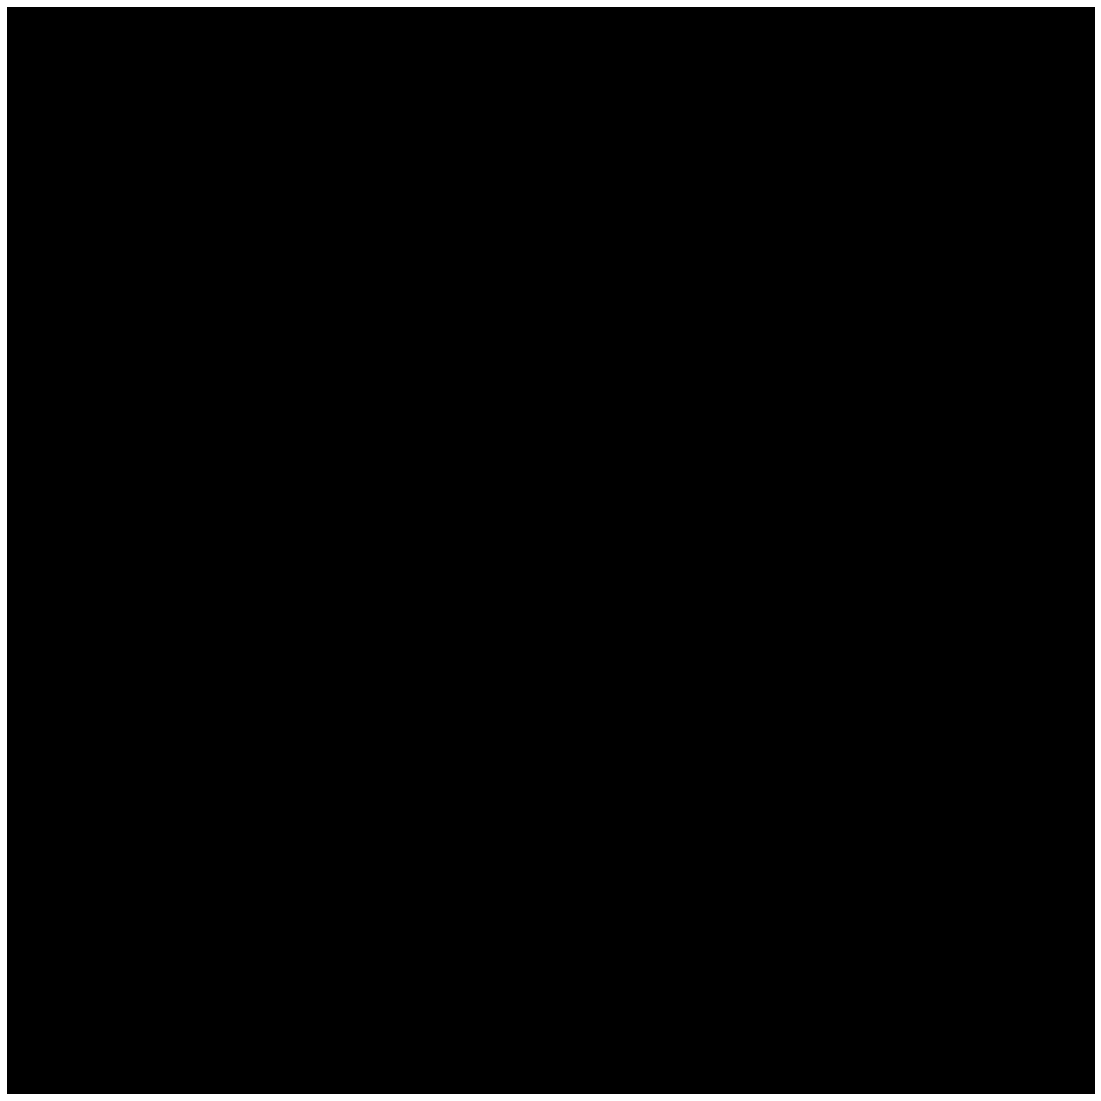

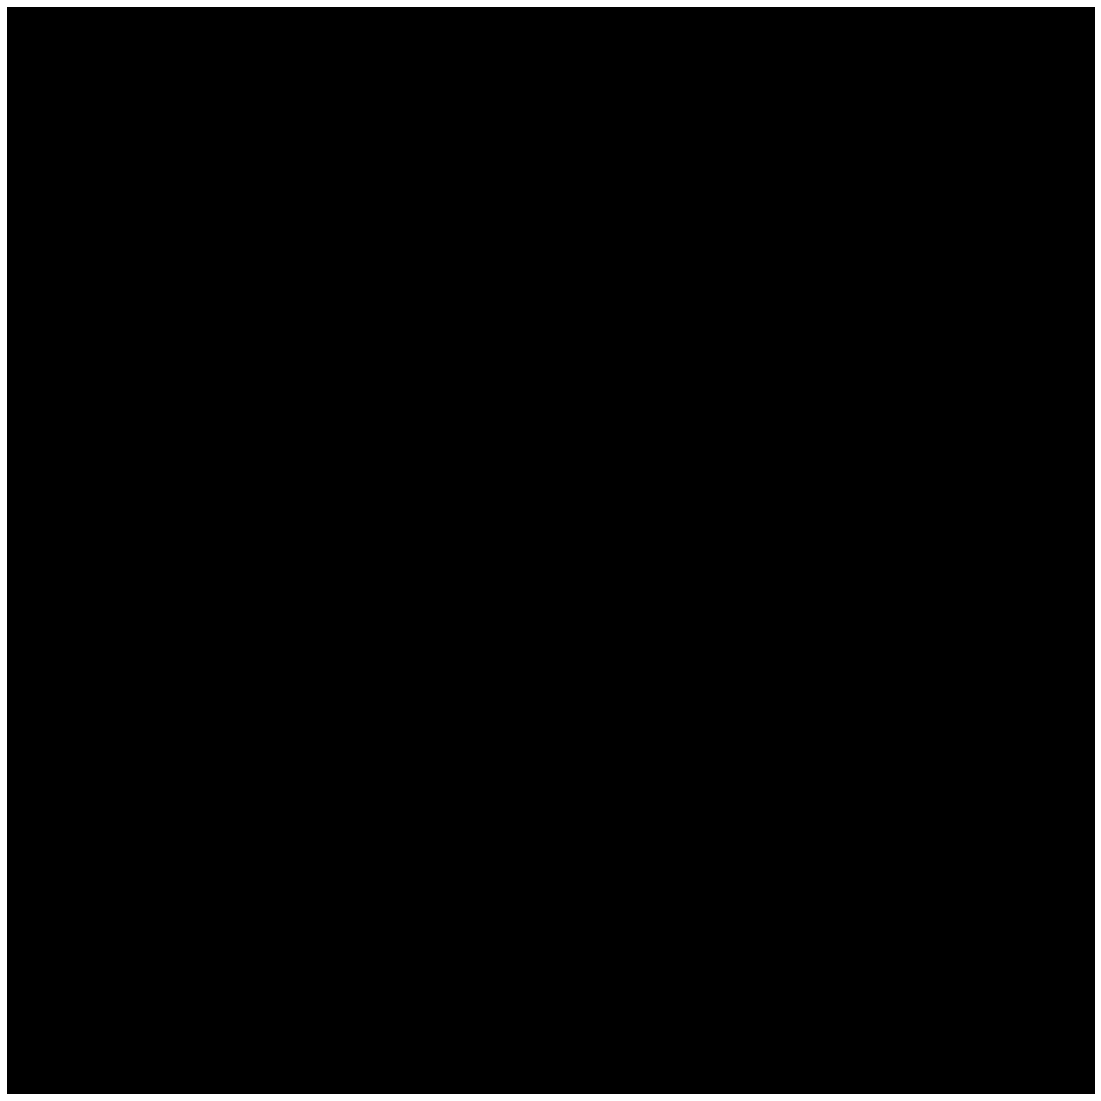

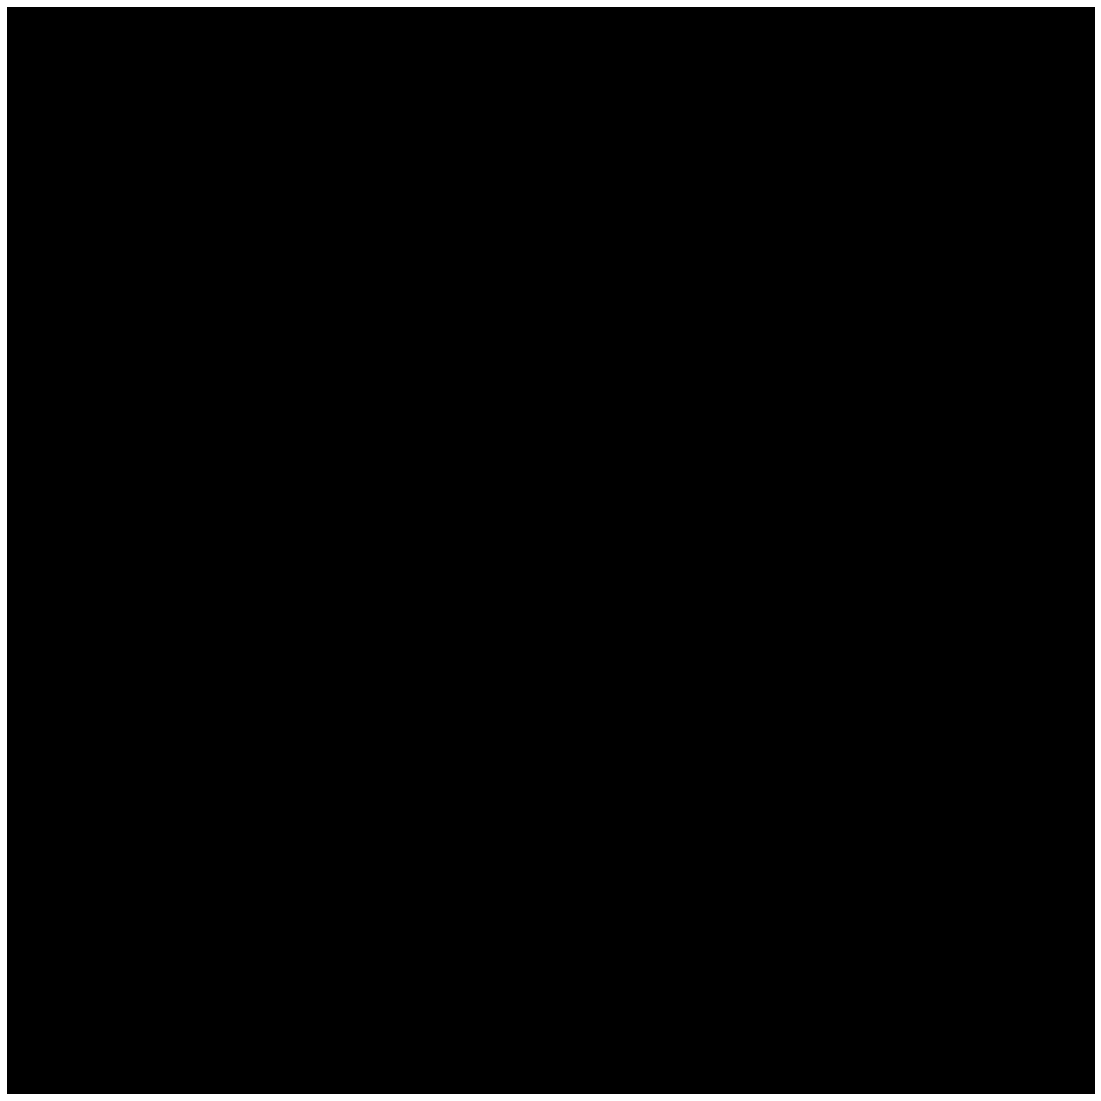

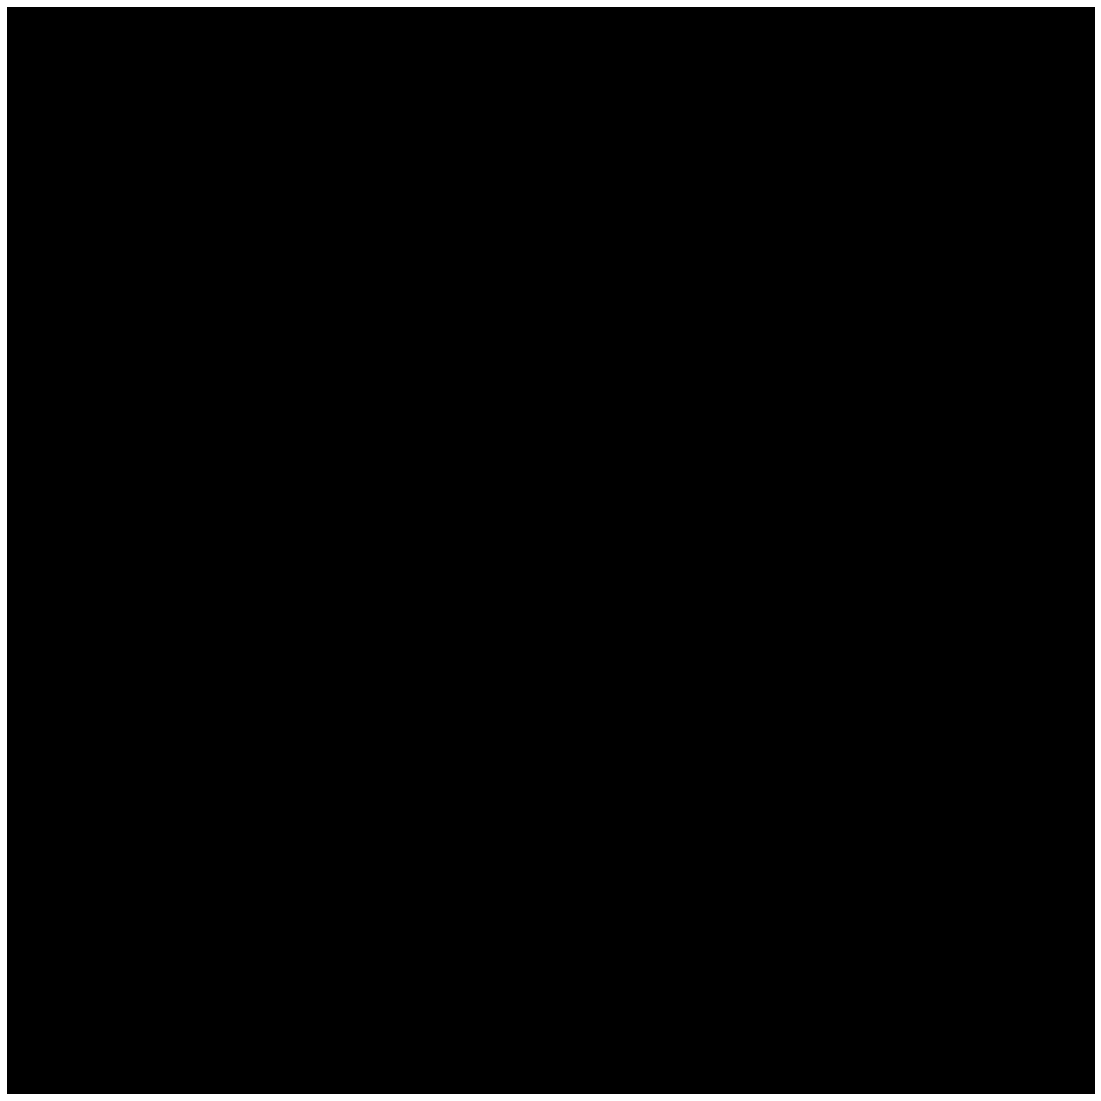

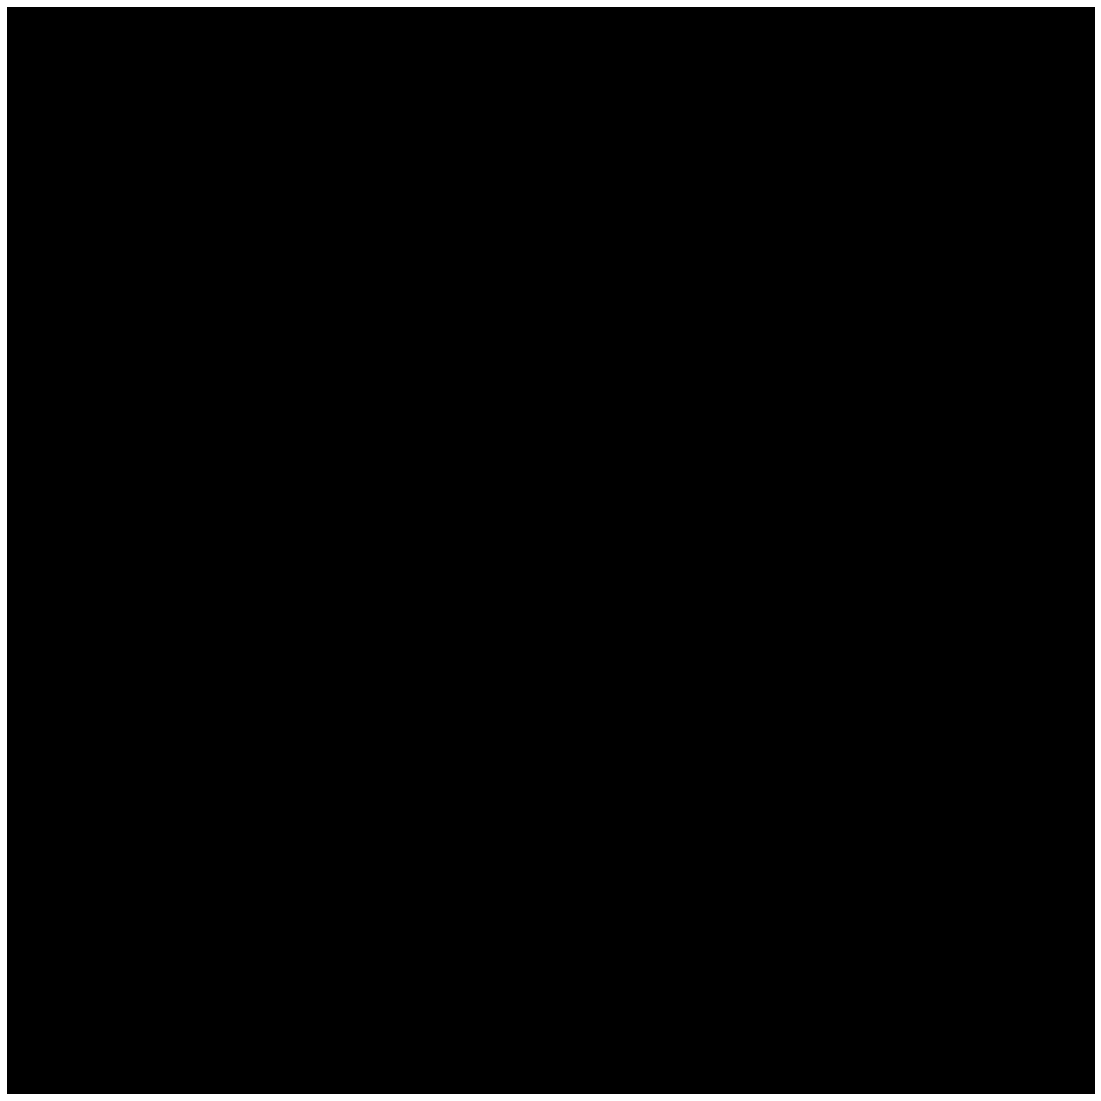

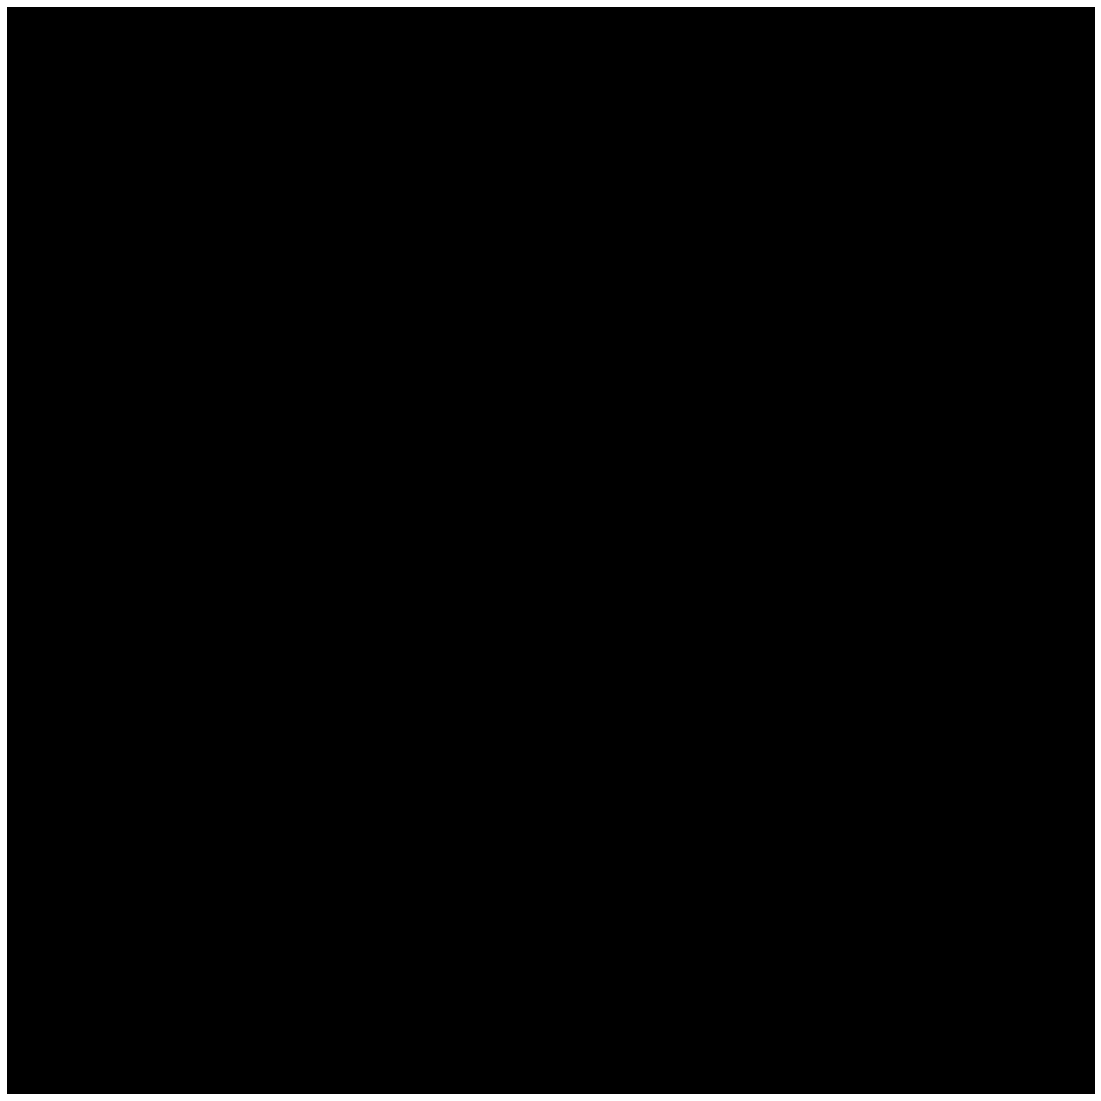

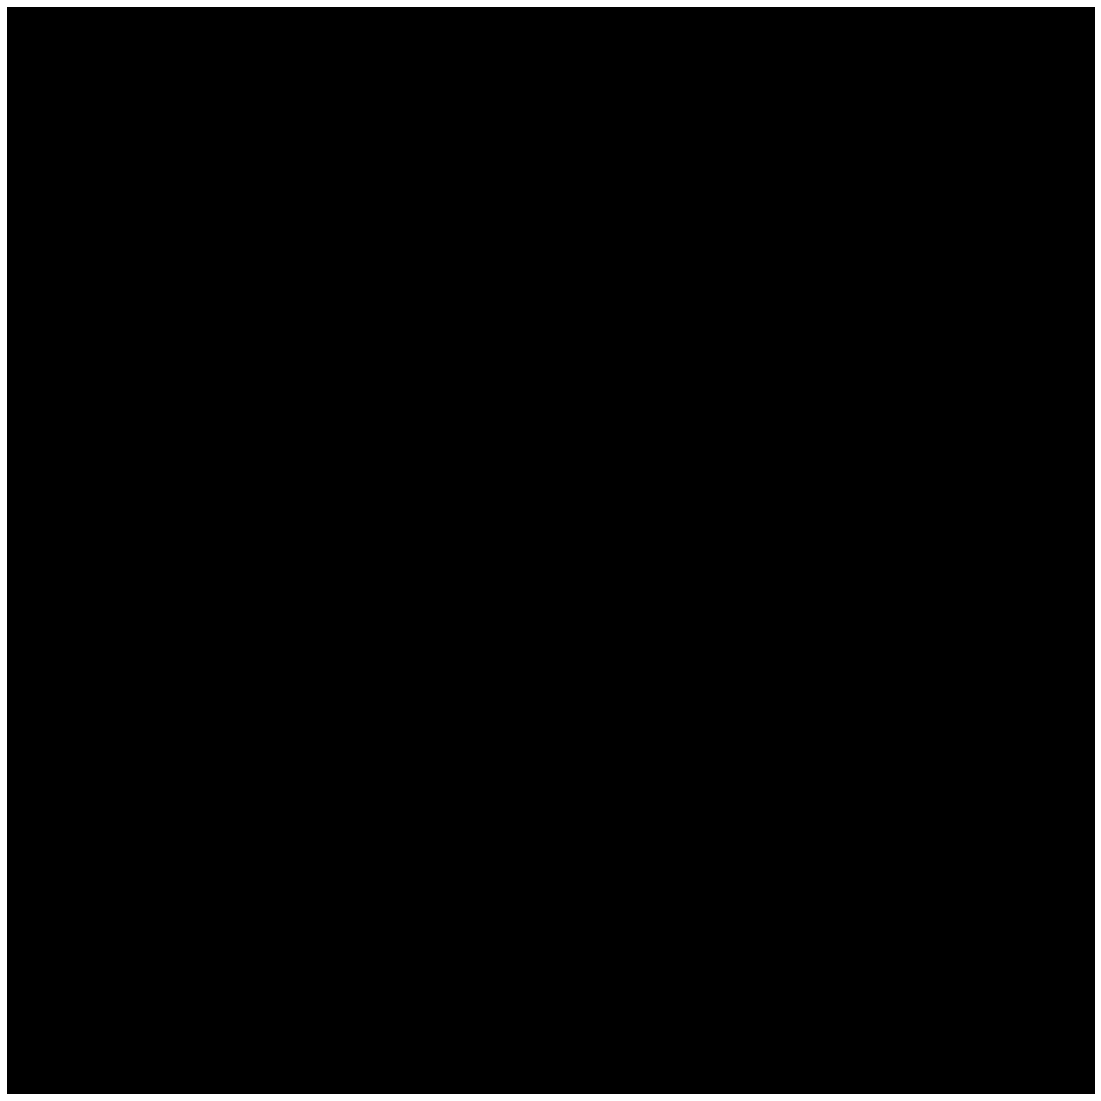

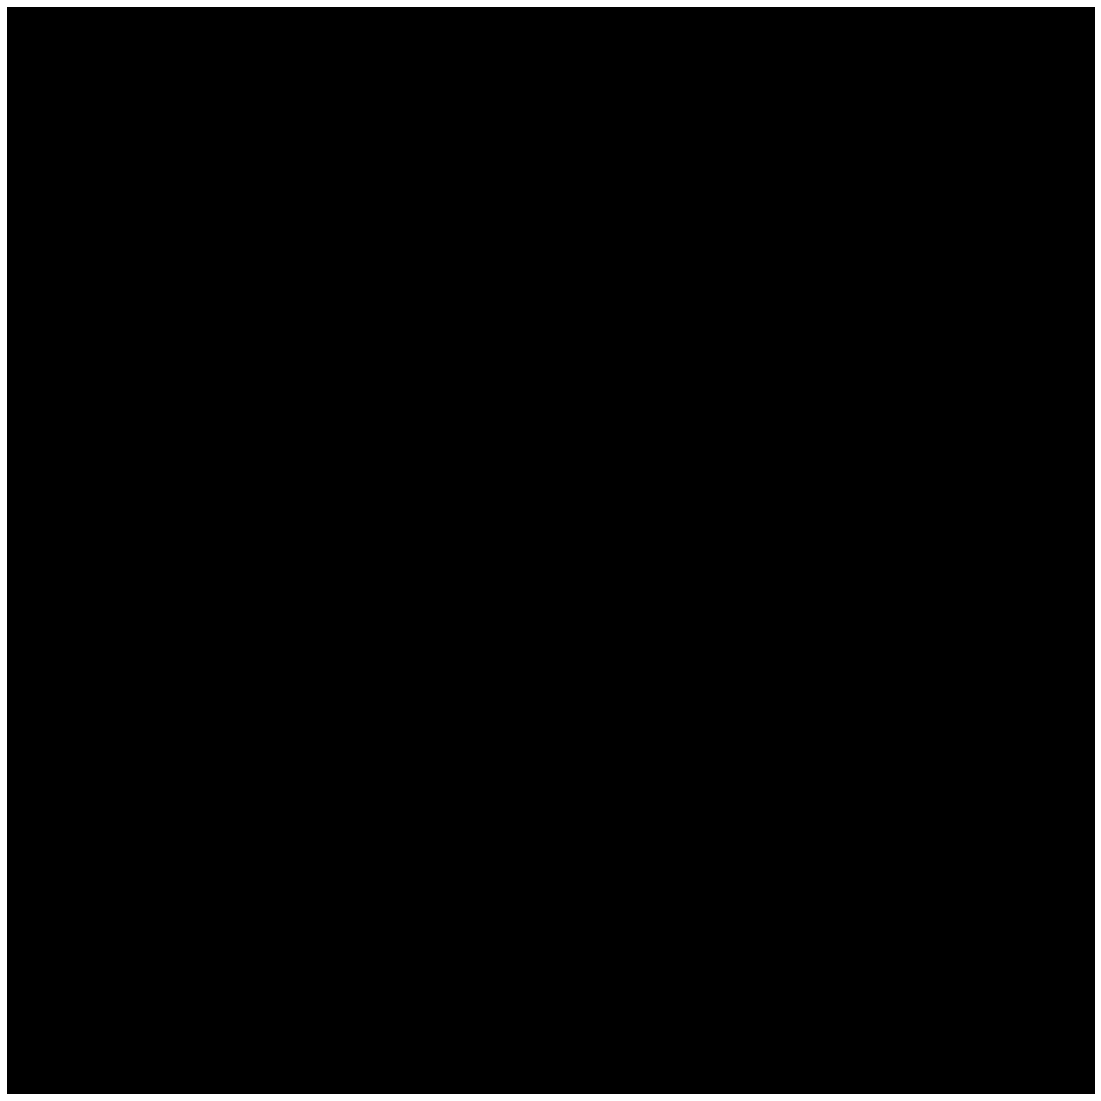

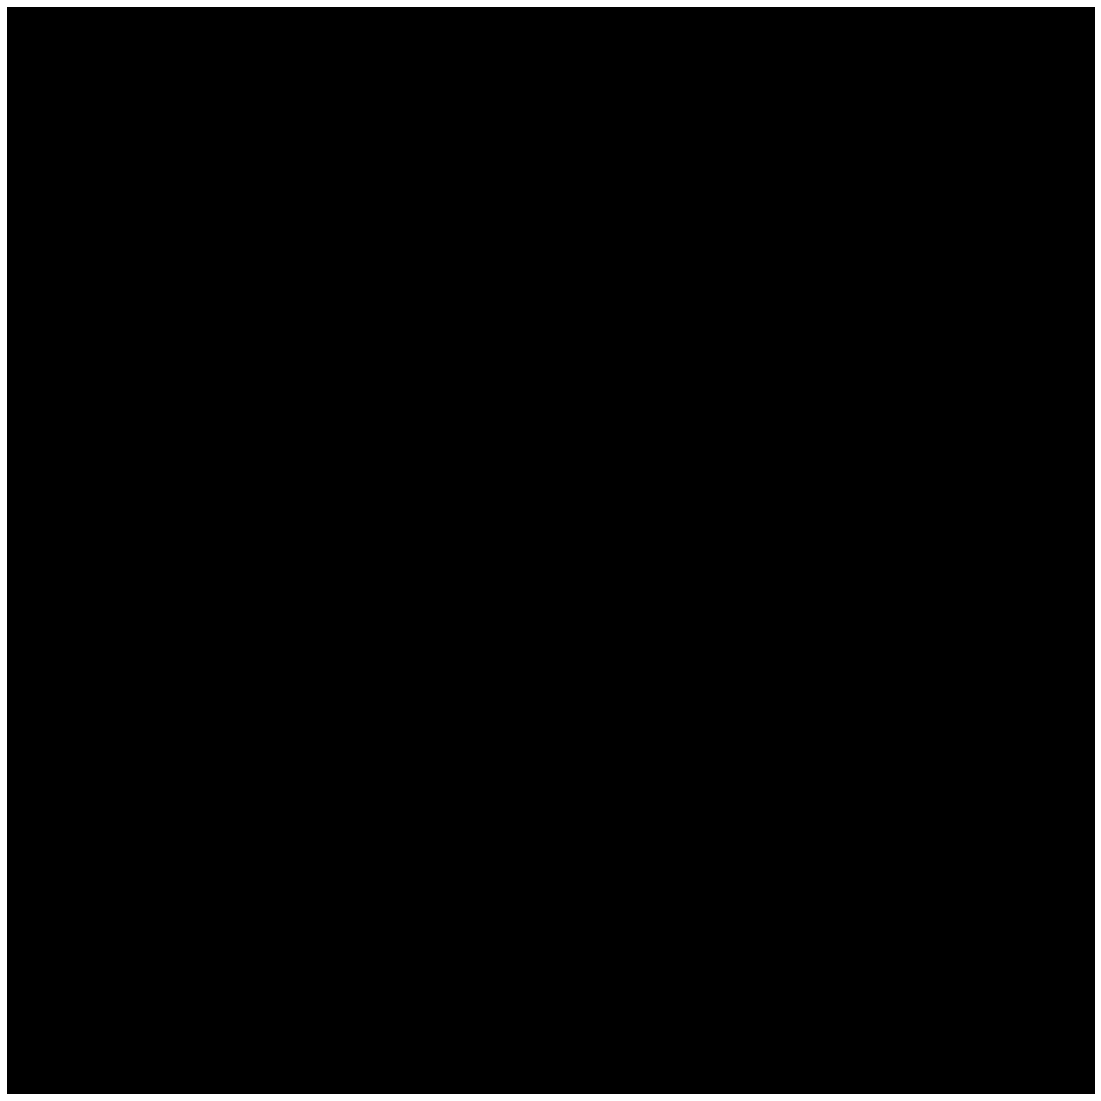

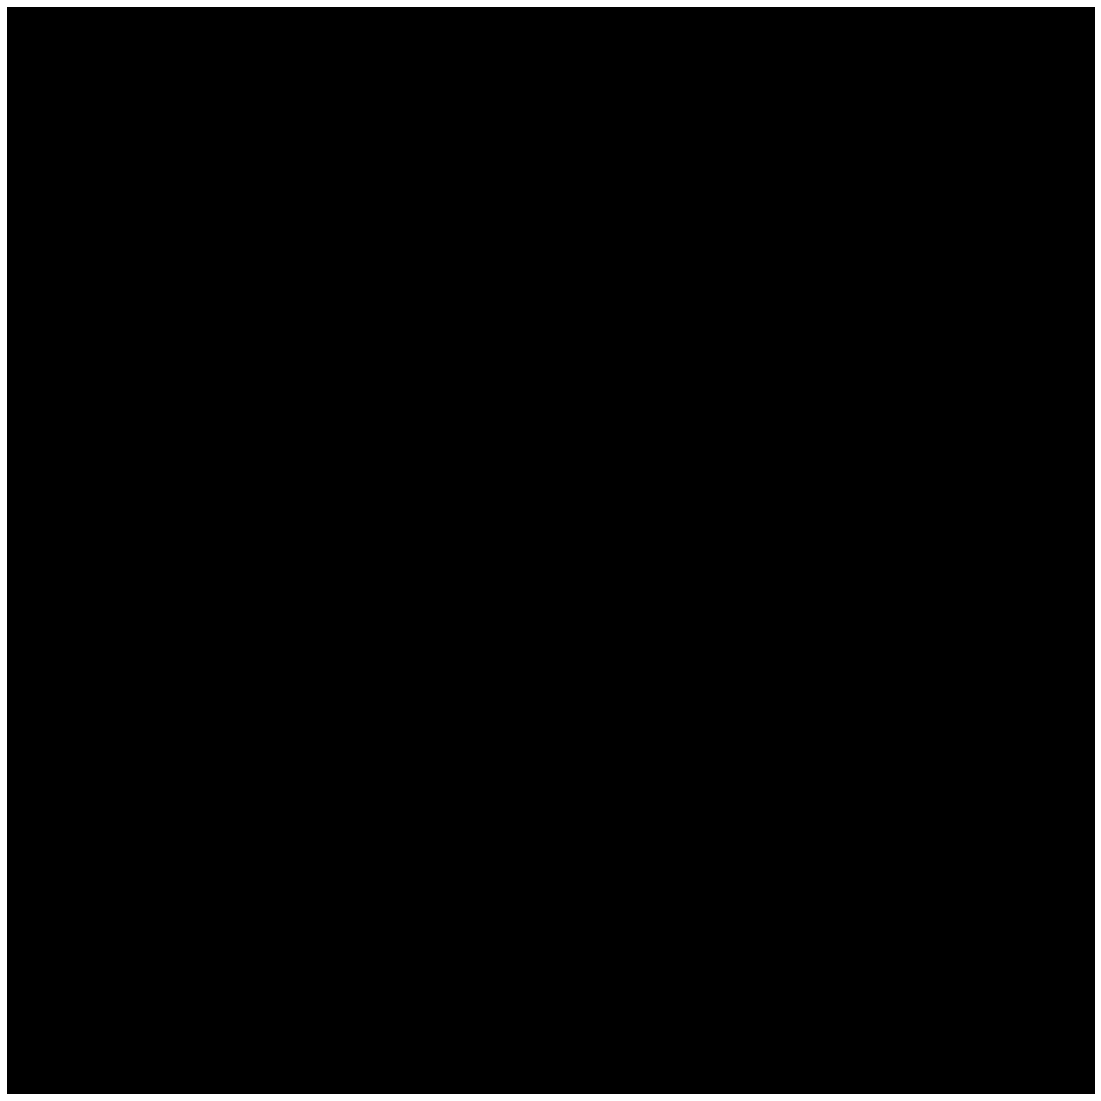

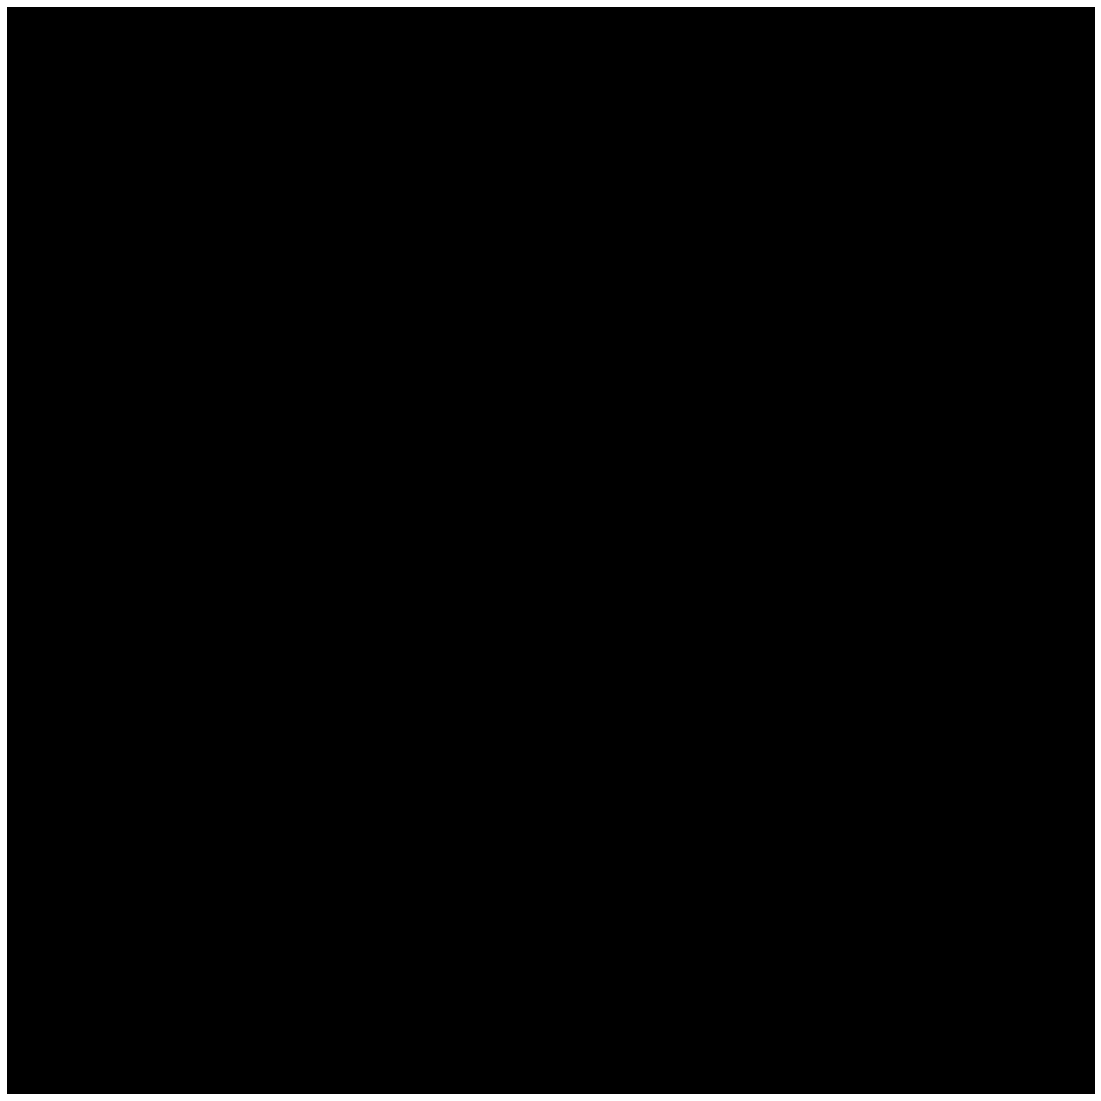

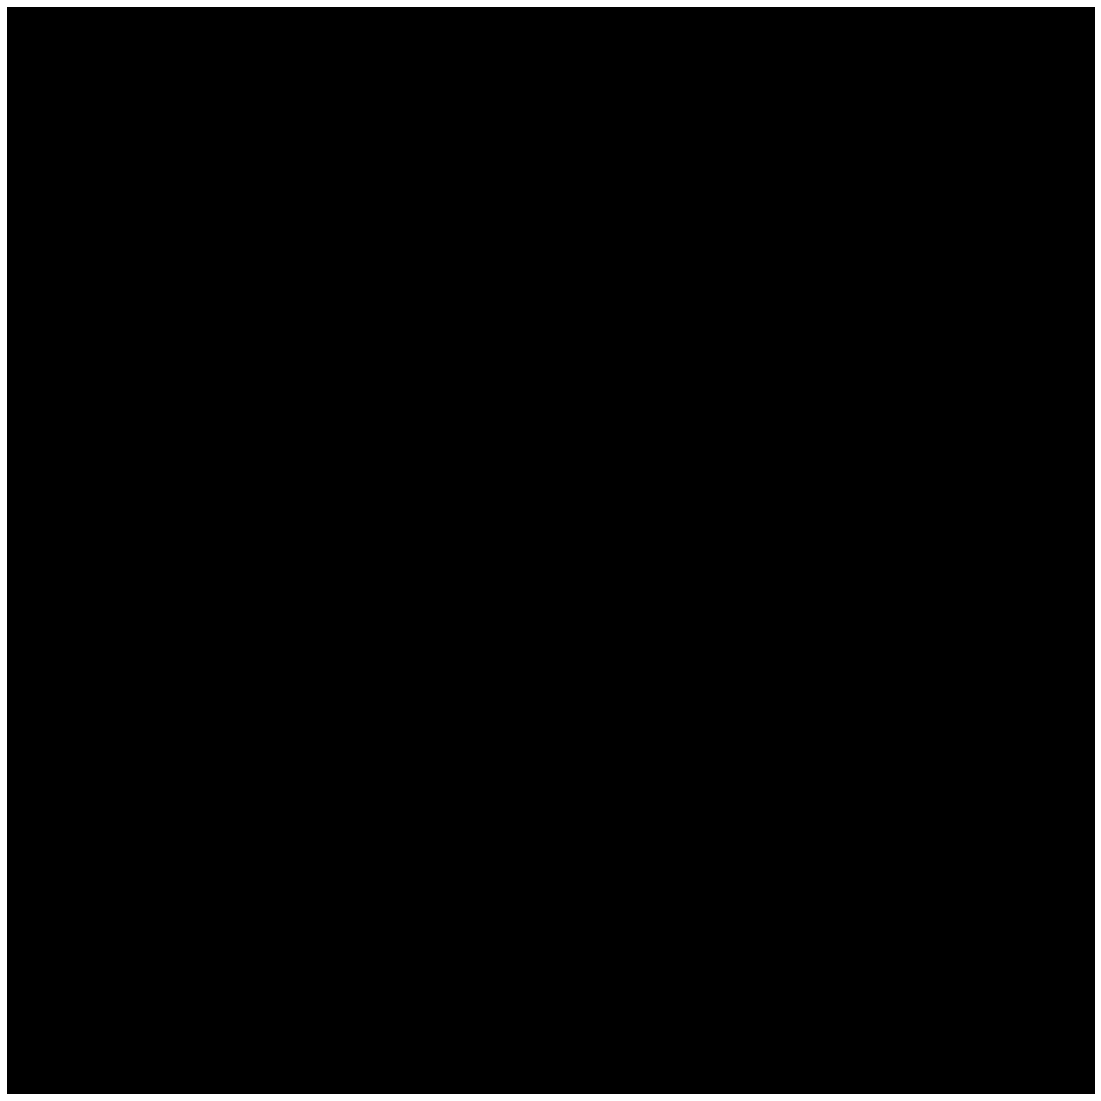

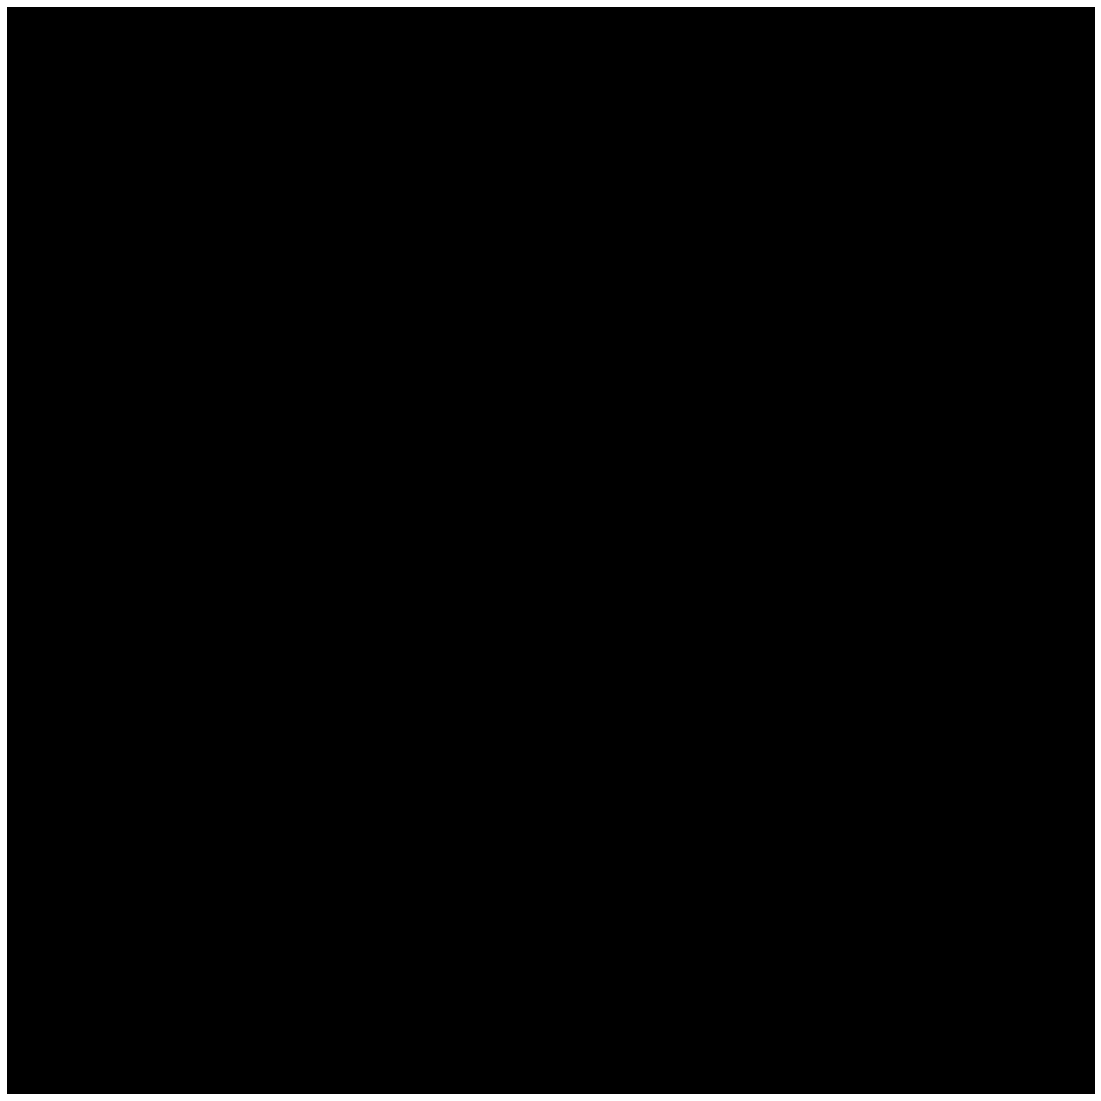

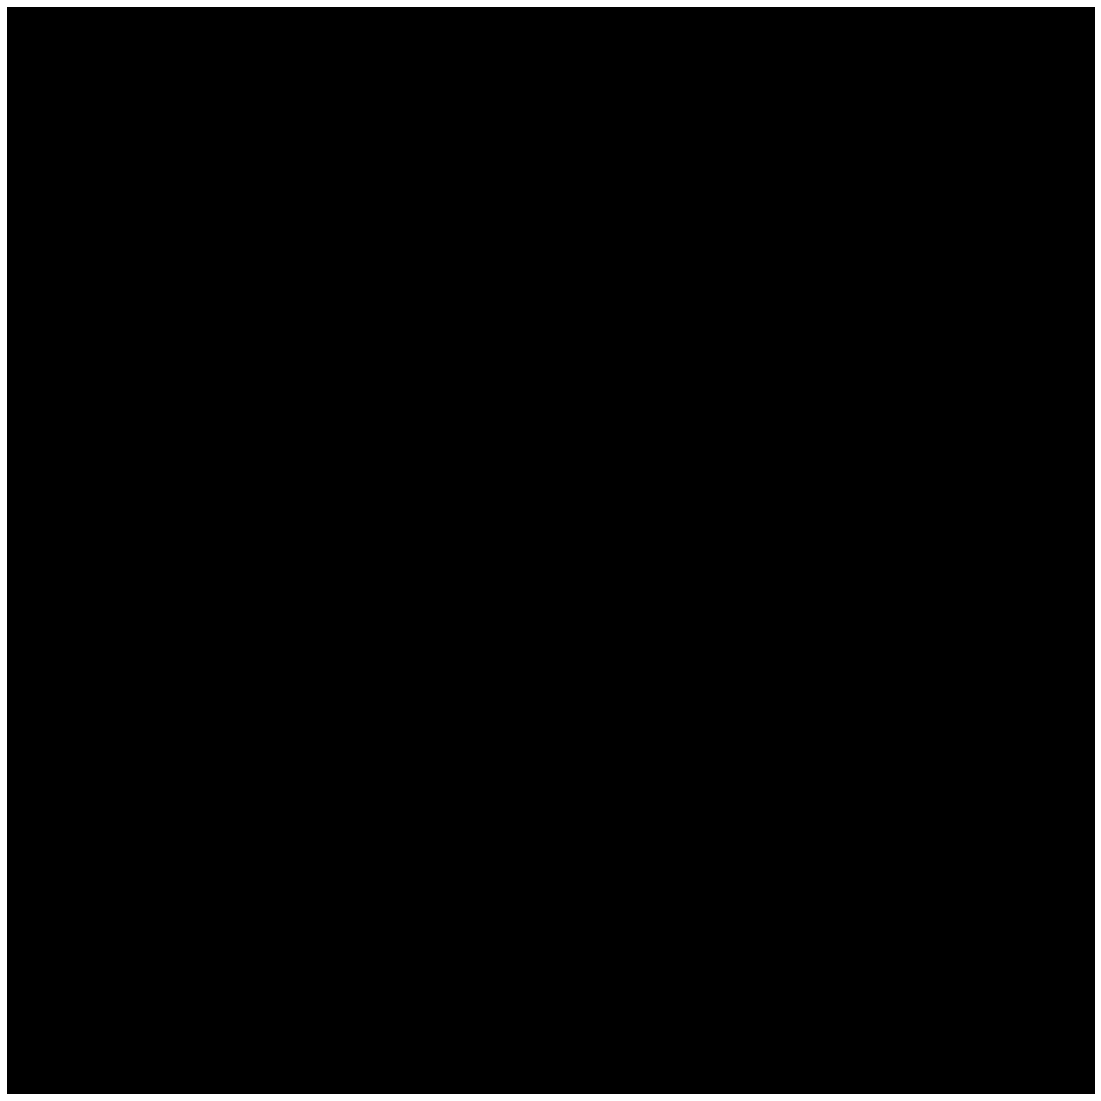

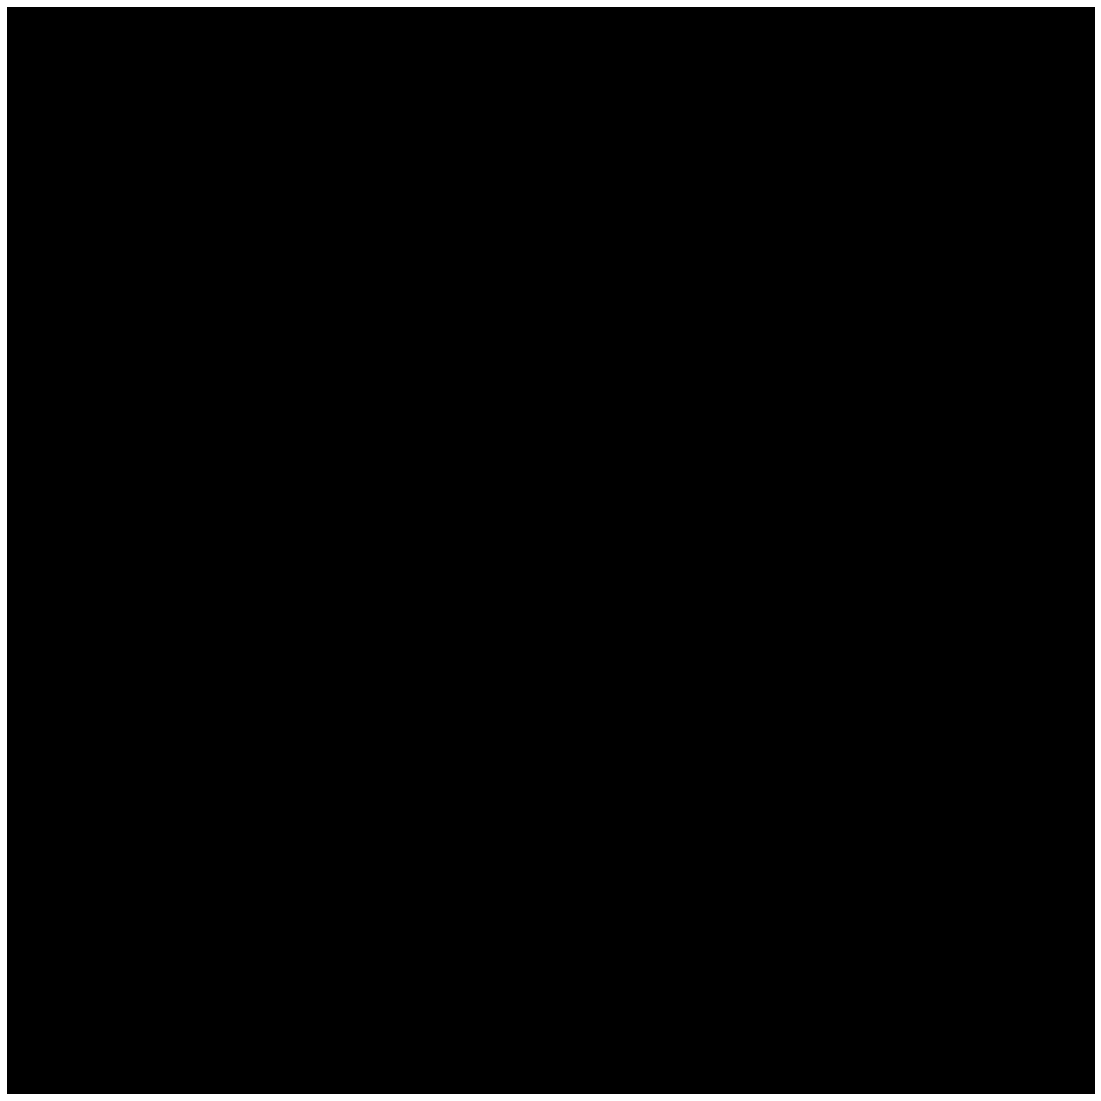

In [ ]:
from torch_snippets import Glob, stem, show, read
# upload your own images to a folder
image_paths = '/content/busimage.jpeg'
for f in image_paths:
  !./darknet detector test data/obj.data cfg/yolov4-tiny-bus-trucks.cfg backup/yolov4-tiny-bus-trucks_4000.weights {f}
  !mv predictions.jpg {stem(f)}_pred.jpg
for i in Glob('*_pred.jpg'):
  show(read(i, 1), sz=20)